# Trumpfselektion with Deep NN Baseline

Based on script by Thomas Koller 01.10.19

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [98]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
data

,H0,H1,H2,H3,H4,H5,H6,H7,H8,K0,...,E2,E3,E4,E5,E6,E7,E8,Geschoben,Player,Aktion
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1631,2
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,64310,6
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,16721,1
3,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,4
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,72620,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161689,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,55942,3
161690,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,6
161691,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,3
161692,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,60659,6


## Multiclass Classification (without _schieben_)

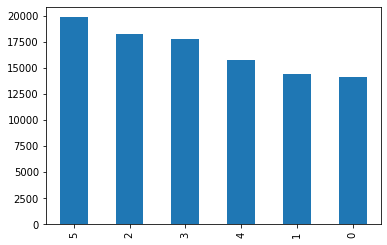

In [99]:
# select subset of data
target_classes = [0,1,2,3,4,5]
num_classes = len(target_classes)
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben'].values.astype(np.float32)
y = zeroone.loc[:,'Aktion']
# print distribution over classes
y.value_counts().plot(kind='bar');
# one-hot
y = keras.utils.to_categorical(y, num_classes=num_classes)

In [100]:
def crossvalidate(build_fn, batch_size, epochs, train_size, test_size, folds, verbose=False):
    np.random.seed(23)
    tf.set_random_seed(23)
    hists = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
    for f in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=test_size, random_state=f)
        model = build_fn()
        hist = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=True)
        for k, v in hist.history.items():
            hists[k] += [v]
    return hists
    
def print_crossvalidated_results(hists):
    acc_mean = np.mean(hists['acc'],axis=0)[-1]
    acc_std = np.std(hists['acc'],axis=0)[-1]
    val_acc_mean = np.mean(hists['val_acc'],axis=0)[-1]
    val_acc_std = np.std(hists['val_acc'],axis=0)[-1]
    print('Accuracy: \n  train %.3f (%.3f-%.3f)\n  val   %.3f (%.3f-%.3f)' % (acc_mean, acc_mean-2*acc_std, acc_mean+2*acc_std, val_acc_mean, val_acc_mean-2*val_acc_std, val_acc_mean+2*val_acc_std))
    fig, ax = plt.subplots(1,2, figsize=(15,3))
    fig.suptitle('Learning Curves of last run')
    ax[0].plot(hists['loss'][-1], label='train')
    ax[0].plot(hists['val_loss'][-1], label='val')
    ax[0].set_title('loss')
    ax[0].legend()
    ax[1].plot(hists['acc'][-1], label='train')
    ax[1].plot(hists['val_acc'][-1], label='val')
    ax[1].set_title('accuracy')
    ax[1].legend();

In [101]:
import pathlib
def save_hists(name, hists, path='./metrics/07_Jass_NN_multi/'):
    file = pathlib.Path(path+name)
    if file.exists():
        file.unlink()
    np.savez(file, **hists)
def load_hists(name, path='./metrics/07_Jass_NN_multi/'):
    file = pathlib.Path(path+name+str('.npz'))
    container = np.load(file)
    return {key:value for (key, value) in container.items()}

### Baseline with architecture by Thomas Koller (but whithout _schieben_)

Using three hidden layers with 16*37 i.e. 592 hidden neurons an relu each seems to result in high overfitting (even on full 80K trainings set!)

In [71]:
def koller_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(37*16, activation='relu', input_shape=[37]))
    model.add(keras.layers.Dense(37*16, activation='relu'))
    model.add(keras.layers.Dense(37*16, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy: 
  train 1.000 (1.000-1.000)
  val   0.694 (0.678-0.710)
CPU times: user 57 s, sys: 4.29 s, total: 1min 1s
Wall time: 42.5 s


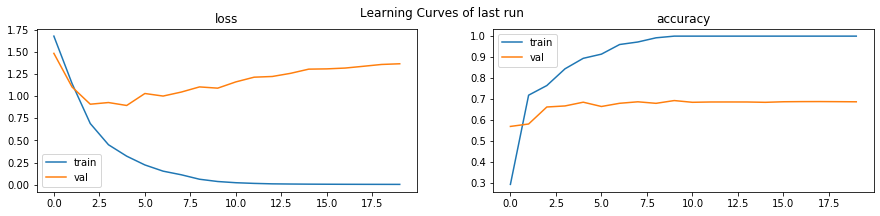

In [7]:
%%time
epochs = 20
batch_size = 64
hists_k_500 = crossvalidate(koller_model, batch_size, epochs, 500, 10000, 5)
save_hists('hists_k_500', hists_k_500)
print_crossvalidated_results(hists_k_500)

Accuracy: 
  train 1.000 (1.000-1.000)
  val   0.726 (0.713-0.738)
CPU times: user 51.8 s, sys: 3.24 s, total: 55 s
Wall time: 38.7 s


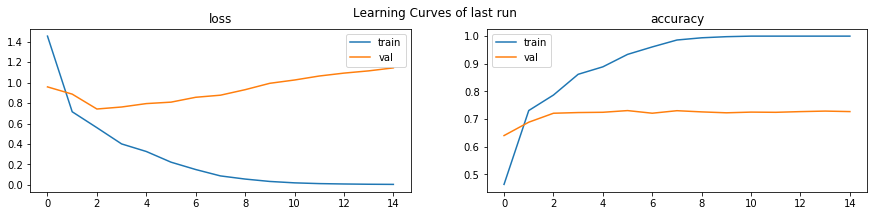

In [8]:
%%time
epochs = 15
batch_size = 64
hists_k_1000 = crossvalidate(koller_model, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_k_1000', hists_k_1000)
print_crossvalidated_results(hists_k_1000)

Accuracy: 
  train 0.981 (0.977-0.984)
  val   0.744 (0.736-0.752)
CPU times: user 3min 32s, sys: 14.5 s, total: 3min 47s
Wall time: 2min 24s


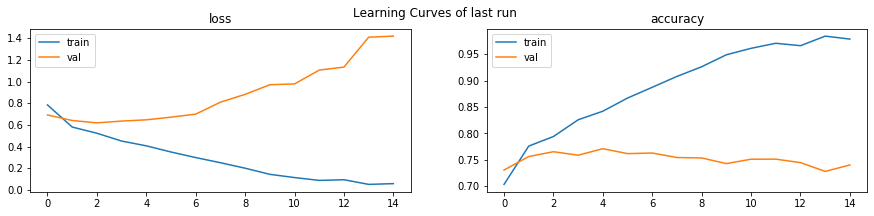

In [9]:
%%time
epochs = 15
batch_size = 64
hists_k_10000 = crossvalidate(koller_model, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_k_10000', hists_k_10000)
print_crossvalidated_results(hists_k_10000)

Accuracy: 
  train 0.975 (0.974-0.977)
  val   0.762 (0.755-0.768)
CPU times: user 49min 6s, sys: 6min 3s, total: 55min 10s
Wall time: 17min 2s


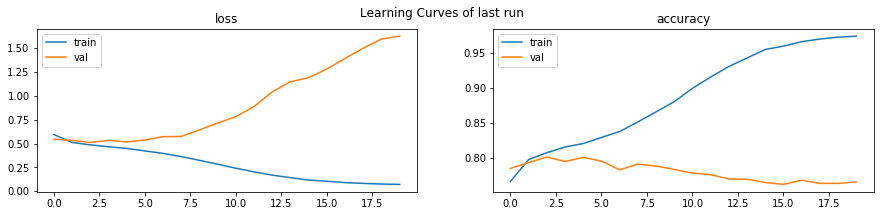

In [72]:
%%time
epochs = 20
batch_size = 64
hists_k_80000 = crossvalidate(koller_model, batch_size, epochs, 0.8, None, 5)
save_hists('hists_k_80000', hists_k_80000)
print_crossvalidated_results(hists_k_80000)

### Linear Model

We even get same validation accuracy of 76% with a linear model on only 10K training samples.

In [7]:
def linear_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_classes, activation='softmax', input_shape=[37]))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Accuracy: 
  train 0.810 (0.771-0.849)
  val   0.683 (0.673-0.693)
CPU times: user 2min 14s, sys: 12.6 s, total: 2min 27s
Wall time: 2min 9s


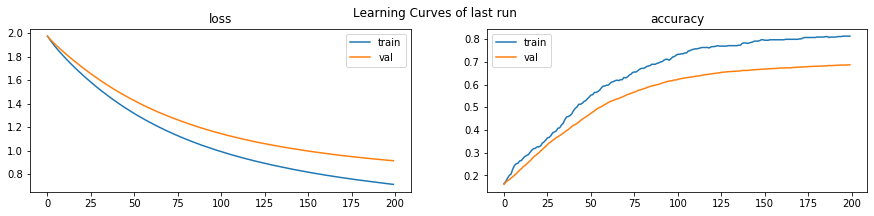

In [10]:
%%time
epochs = 200
batch_size = 64
hists_0_500 = crossvalidate(linear_model, batch_size, epochs, 500, 10000, 5)
save_hists('hists_0_500', hists_0_500)
print_crossvalidated_results(hists_0_500)

Accuracy: 
  train 0.785 (0.758-0.813)
  val   0.718 (0.712-0.724)
CPU times: user 1min 2s, sys: 6.82 s, total: 1min 9s
Wall time: 56.8 s


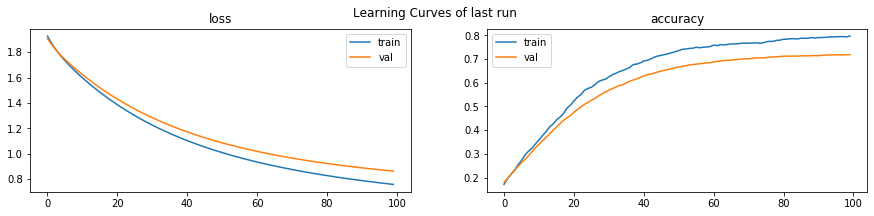

In [8]:
%%time
epochs = 100
batch_size = 64
hists_0_1000 = crossvalidate(linear_model, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_0_1000', hists_0_1000)
print_crossvalidated_results(hists_0_1000)

Accuracy: 
  train 0.775 (0.769-0.782)
  val   0.769 (0.764-0.775)
CPU times: user 31 s, sys: 3.06 s, total: 34.1 s
Wall time: 28.1 s


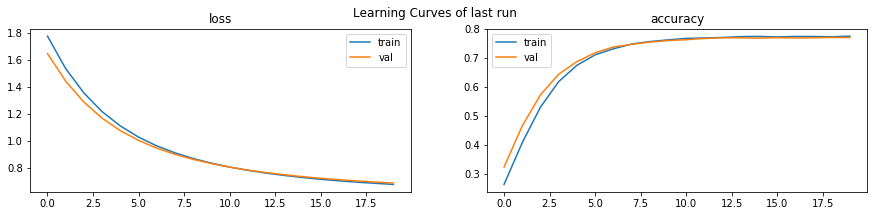

In [9]:
%%time
epochs = 20
batch_size = 64
hists_0_10000 = crossvalidate(linear_model, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_0_10000', hists_0_10000)
print_crossvalidated_results(hists_0_10000)

Accuracy: 
  train 0.771 (0.769-0.773)
  val   0.772 (0.768-0.777)
CPU times: user 2min 8s, sys: 32.7 s, total: 2min 40s
Wall time: 1min 39s


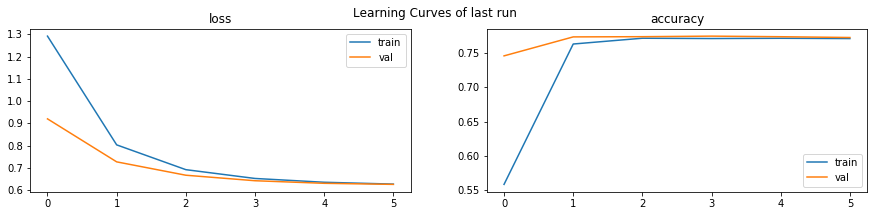

In [80]:
%%time
epochs = 6
batch_size = 64
hists_0_80000 = crossvalidate(linear_model, batch_size, epochs, 0.8, None, 5)
save_hists('hists_0_80000', hists_0_80000)
print_crossvalidated_results(hists_0_80000)

### Deep model (h=4)

Using one hidden layer with only 4 hidden neurons introduces a bottleneck for the 6-class case. Even worse than the linear model.

In [12]:
def deep_model_h4():
    model = keras.Sequential()
    model.add(keras.layers.Dense(4, activation='relu', input_shape=[37]))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Accuracy: 
  train 0.727 (0.693-0.761)
  val   0.602 (0.567-0.637)
CPU times: user 2min 36s, sys: 13.1 s, total: 2min 49s
Wall time: 2min 25s


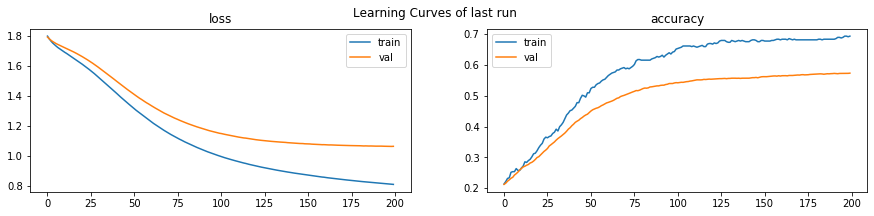

In [12]:
%%time
epochs = 200
batch_size = 64
hists_4_500 = crossvalidate(deep_model_h4, batch_size, epochs, 500, 10000, 5)
save_hists('hists_4_500', hists_4_500)
print_crossvalidated_results(hists_4_500)

Accuracy: 
  train 0.687 (0.626-0.747)
  val   0.627 (0.554-0.699)
CPU times: user 2min 21s, sys: 9.92 s, total: 2min 31s
Wall time: 2min 9s


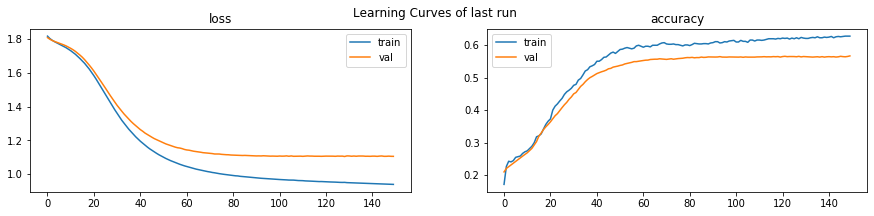

In [13]:
%%time
epochs = 150
batch_size = 64
hists_4_1000 = crossvalidate(deep_model_h4, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_4_1000', hists_4_1000)
print_crossvalidated_results(hists_4_1000)

Accuracy: 
  train 0.690 (0.671-0.710)
  val   0.687 (0.672-0.702)
CPU times: user 1min 6s, sys: 5.57 s, total: 1min 12s
Wall time: 1min 1s


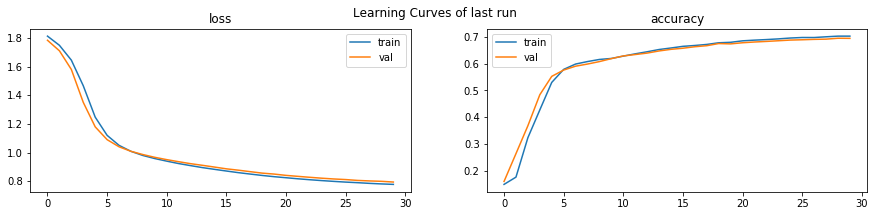

In [14]:
%%time
epochs = 30
batch_size = 64
hists_4_10000 = crossvalidate(deep_model_h4, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_4_10000', hists_4_10000)
print_crossvalidated_results(hists_4_10000)

Accuracy: 
  train 0.707 (0.699-0.716)
  val   0.710 (0.705-0.714)
CPU times: user 2min 51s, sys: 1min 1s, total: 3min 53s
Wall time: 2min 1s


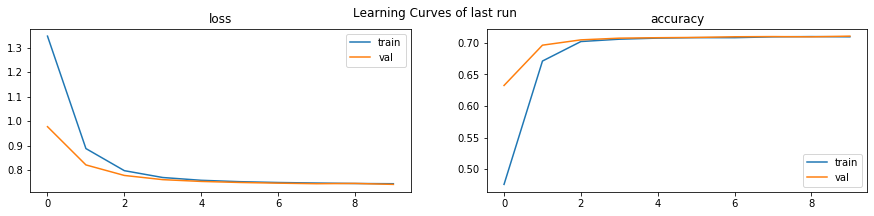

In [16]:
%%time
epochs = 10
batch_size = 64
hists_4_80000 = crossvalidate(deep_model_h4, batch_size, epochs, 0.8, None, 5)
save_hists('hists_4_80000', hists_4_80000)
print_crossvalidated_results(hists_4_80000)

### Deep model (h=16)

Also increasing the hidden layer does not improve val-accuracy. But it already leads to more overfitting especially with few training-data.

In [34]:
def deep_model_h16():
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=[37]))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Accuracy: 
  train 0.863 (0.842-0.884)
  val   0.699 (0.686-0.713)
CPU times: user 2min 2s, sys: 8.56 s, total: 2min 10s
Wall time: 1min 55s


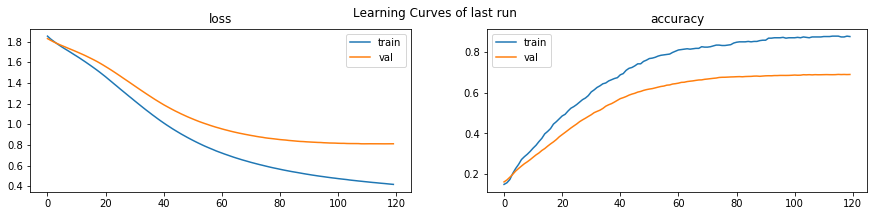

In [16]:
%%time
epochs = 120
batch_size = 64
hists_16_500 = crossvalidate(deep_model_h16, batch_size, epochs, 500, 10000, 5)
save_hists('hists_16_500', hists_16_500)
print_crossvalidated_results(hists_16_500)

Accuracy: 
  train 0.820 (0.802-0.839)
  val   0.733 (0.725-0.740)
CPU times: user 1min 27s, sys: 5.36 s, total: 1min 33s
Wall time: 1min 23s


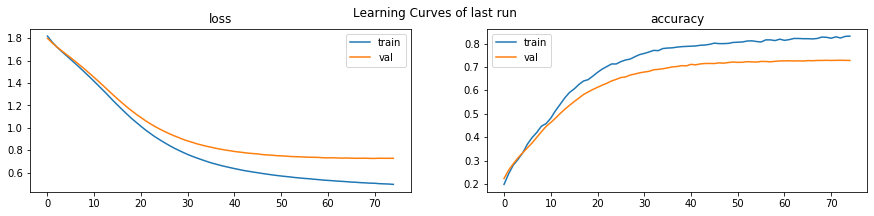

In [17]:
%%time
epochs = 75
batch_size = 64
hists_16_1000 = crossvalidate(deep_model_h16, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_16_1000', hists_16_1000)
print_crossvalidated_results(hists_16_1000)

Accuracy: 
  train 0.776 (0.768-0.784)
  val   0.770 (0.766-0.774)
CPU times: user 50.7 s, sys: 12.5 s, total: 1min 3s
Wall time: 38.4 s


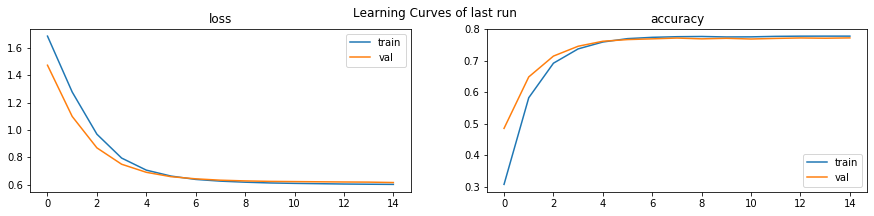

In [26]:
%%time
epochs = 15
batch_size = 64
hists_16_10000 = crossvalidate(deep_model_h16, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_16_10000', hists_16_10000)
print_crossvalidated_results(hists_16_10000)

Accuracy: 
  train 0.806 (0.802-0.809)
  val   0.804 (0.799-0.808)
CPU times: user 16min 44s, sys: 3min 54s, total: 20min 39s
Wall time: 13min 26s


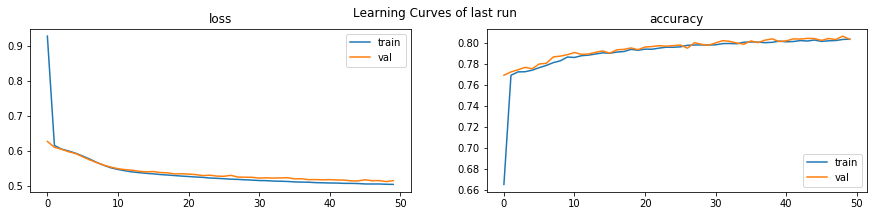

In [75]:
%%time
epochs = 50
batch_size = 64
hists_16_80000 = crossvalidate(deep_model_h16, batch_size, epochs, 0.8, None, 5)
save_hists('hists_16_80000', hists_16_80000)
print_crossvalidated_results(hists_16_80000)

## Load and plot results

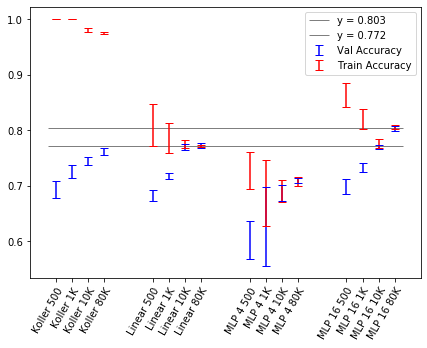

In [108]:
x_ticks = [0,1,2,3,6,7,8,9,12,13,14,15,18,19,20,21]
all_hists_names = ['hists_k_500', 'hists_k_1000', 'hists_k_10000', 'hists_k_80000', 'hists_0_500', 'hists_0_1000', 'hists_0_10000', 'hists_0_80000', 'hists_4_500', 'hists_4_1000', 'hists_4_10000', 'hists_4_80000', 'hists_16_500', 'hists_16_1000', 'hists_16_10000', 'hists_16_80000']
all_hists = [load_hists(name) for name in all_hists_names]
test_acc_mean = [np.mean(h['val_acc'],axis=0)[-1] for h in all_hists]
test_acc_std = [np.std(h['val_acc'],axis=0)[-1]*1.96 for h in all_hists]
train_acc_mean = [np.mean(h['acc'],axis=0)[-1] for h in all_hists]
train_acc_std = [np.std(h['acc'],axis=0)[-1]*1.96 for h in all_hists]
train_sizes = ['500','1K','10K', '80K']
labels = ['Koller '+s for s in train_sizes]+['Linear '+s for s in train_sizes]+['MLP 4 '+s for s in train_sizes]+['MLP 16 '+s for s in train_sizes]

plt.figure(figsize=(7,5))
plt.hlines(0.803,-0.5,21.5,linewidth=1,color=[0,0,0,0.5], label='y = 0.803')
plt.hlines(0.772,-0.5,21.5,linewidth=1,color=[0,0,0,0.5], label='y = 0.772')
plt.errorbar(x_ticks,test_acc_mean,yerr=test_acc_std, markersize=0, capsize=4, ecolor='b', fmt='b.', label='Val Accuracy')
plt.errorbar(x_ticks,train_acc_mean,yerr=train_acc_std, markersize=0, capsize=4, ecolor='r', fmt='b.', label='Train Accuracy')
plt.xticks(x_ticks, labels=labels, rotation=60, ha='right', rotation_mode="anchor");
plt.legend();